Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Plot the distribution of your target. 
    - Classification problem: Are your classes imbalanced? Then, don't use just accuracy.
    - Regression problem: Is your target skewed? If so, let's discuss in Slack.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline?
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [1]:
DATA_PATH = './data/vgsales/vgsales-12-4-2019.csv'
import pandas as pd
df = pd.read_csv(DATA_PATH)
pd.set_option('display.max_columns', 23)
pd.set_option("display.max_rows", 100)
df.head()

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,NaN,82.86,NaN,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,NaN,40.24,NaN,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,9.1,37.14,NaN,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg
3,4,PlayerUnknown's Battlegrounds,playerunknowns-battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,NaN,36.60,NaN,NaN,NaN,NaN,NaN,2017.0,13th Nov 18,http://www.vgchartz.com/game/215988/playerunkn...,1,NaN,/games/boxart/full_8052843AmericaFrontccc.jpg
4,5,Wii Sports Resort,wii-sports-resort,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,8.0,8.8,33.09,NaN,NaN,NaN,NaN,NaN,2009.0,NaN,http://www.vgchartz.com/game/24656/wii-sports-...,1,8.8,/games/boxart/full_7295041AmericaFrontccc.jpg


In [2]:
'''
Drop the following columns:
- basename: a rewritten version of the game's name that's not necessary for data wrangling
- VGChartz_Score: All values are null, and there's another vgchartzscore column with values
- url: the link to the vgchartz page that the data was collected from. Not needed for data wrangling
- img_url: boxart can affect game sales, but it's not quantifiable and out of scope for this assignment
- status: It's always 1, and there's no documentation on what status is anyways
- Last_Update: At first, I thought this was the date the game itself was last updated, but it's not.
  (Mario Kart Wii for instance was not updated on April 13, 2018.)
  It might be the last time Vgchartz updated their charts for the game, which would mean this is
  irrelevant too.
'''

df = df.drop(['basename','VGChartz_Score','url','img_url','status','Last_Update'],axis=1)

'''
Total_Shipped and Global_Sales appear to share identical data, just that games in
Total_Shipped do not have listed regional sales.
Let's make a new column, All_Sales, that combines the total shipped and global sales data
'''
import numpy as np

def addStuff(x):
    if (np.isnan(x)):
        return 0
    else:
        return x

df['All_Sales'] = 1
df['All_Sales'] = df['Global_Sales'].apply(addStuff) + df['Total_Shipped'].apply(addStuff)

# Drop rows that don't have any sales numbers, our target.
df = df[df['All_Sales'] > 0]

df.head(21)

,Rank,Name,Genre,ESRB_Rating,Platform,Publisher,Developer,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Vgchartzscore,All_Sales
0,1,Wii Sports,Sports,E,Wii,Nintendo,Nintendo EAD,7.7,NaN,82.86,NaN,NaN,NaN,NaN,NaN,2006.0,NaN,82.86
1,2,Super Mario Bros.,Platform,NaN,NES,Nintendo,Nintendo EAD,10.0,NaN,40.24,NaN,NaN,NaN,NaN,NaN,1985.0,NaN,40.24
2,3,Mario Kart Wii,Racing,E,Wii,Nintendo,Nintendo EAD,8.2,9.1,37.14,NaN,NaN,NaN,NaN,NaN,2008.0,8.7,37.14
3,4,PlayerUnknown's Battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,36.60,NaN,NaN,NaN,NaN,NaN,2017.0,NaN,36.60
4,5,Wii Sports Resort,Sports,E,Wii,Nintendo,Nintendo EAD,8.0,8.8,33.09,NaN,NaN,NaN,NaN,NaN,2009.0,8.8,33.09
5,6,Pokemon Red / Green / Blue Version,Role-Playing,E,GB,Nintendo,Game Freak,9.4,NaN,31.38,NaN,NaN,NaN,NaN,NaN,1998.0,NaN,31.38
6,7,New Super Mario Bros.,Platform,E,DS,Nintendo,Nintendo EAD,9.1,8.1,30.80,NaN,NaN,NaN,NaN,NaN,2006.0,NaN,30.80
7,8,Tetris,Puzzle,E,GB,Nintendo,Bullet Proof Software,NaN,NaN,30.26,NaN,NaN,NaN,NaN,NaN,1989.0,NaN,30.26
8,9,New Super Mario Bros. Wii,Platform,E,Wii,Nintendo,Nintendo EAD,8.6,9.2,30.22,NaN,NaN,NaN,NaN,NaN,2009.0,9.1,30.22
9,10,Minecraft,Misc,NaN,PC,Mojang,Mojang AB,10.0,NaN,30.01,NaN,NaN,NaN,NaN,NaN,2010.0,NaN,30.01


In [3]:
df.shape

(19862, 18)

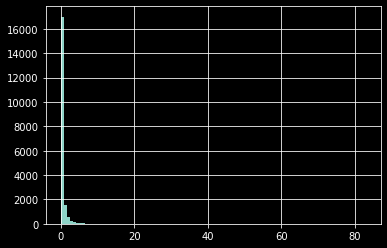

In [4]:
df['All_Sales'].hist(bins=100)

In [5]:
df['All_Sales'].describe()

count    19862.000000
mean         0.530876
std          1.572634
min          0.010000
25%          0.050000
50%          0.160000
75%          0.450000
max         82.860000
Name: All_Sales, dtype: float64

I have decided to make this dataset a **classification problem**. I will guess if a game sells more than 100,000 copies based on various features.

In [6]:
# Create a new column that states True if game sold more than 100k, or False if it sold less.

df['Sold_100k'] = df['All_Sales'] >=0.1

In [7]:
df['Sold_100k'].describe()

count     19862
unique        2
top        True
freq      12642
Name: Sold_100k, dtype: object

In [8]:
df['Sold_100k'].value_counts(normalize=True)

True     0.636492
False    0.363508
Name: Sold_100k, dtype: float64

The baseline is 63.6%. If we were to completely guess if a game on this list sold more than 100k, we'd be right 63.6% of the time.

In [9]:
# Other features to engineer later:
# - Average score (take mean of critic, user, and vgchartz score
# - Is unique (Is the game available in multiple platforms?)
# - Percent distribution of regional sales

I will use a random split because if I were to split by date, I'd have a harder time predicting sales based on game platform.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train, val = train_test_split(df,random_state=84)
train.shape, val.shape

((14896, 19), (4966, 19))

In [17]:
train.describe()

,Rank,Critic_Score,User_Score,Total_Shipped,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Vgchartzscore,All_Sales
count,14896.000000,3510.000000,174.000000,1357.000000,13539.000000,9595.000000,9067.000000,5092.000000,10895.000000,14893.000000,397.000000,14896.000000
mean,9947.314782,7.263903,8.474138,1.814363,0.393390,0.279806,0.168769,0.115328,0.047726,2007.689653,7.583627,0.522838
std,5749.828300,1.411741,1.265308,3.693194,0.851805,0.513047,0.405370,0.190607,0.131878,6.408384,1.365320,1.438188
min,2.000000,1.000000,2.000000,0.030000,0.010000,0.000000,0.000000,0.000000,0.000000,1970.000000,3.000000,0.010000
25%,4962.750000,6.500000,8.000000,0.200000,0.050000,0.050000,0.020000,0.020000,0.000000,2004.000000,7.000000,0.050000
50%,9911.000000,7.500000,8.800000,0.570000,0.140000,0.120000,0.050000,0.050000,0.010000,2008.000000,8.000000,0.160000
75%,14949.500000,8.300000,9.300000,1.800000,0.400000,0.290000,0.160000,0.130000,0.040000,2012.000000,8.600000,0.450000
max,19862.000000,10.000000,10.000000,40.240000,19.390000,9.760000,9.710000,2.690000,3.020000,2020.000000,9.600000,40.240000


In [16]:
train.describe(exclude='number')

,Name,Genre,ESRB_Rating,Platform,Publisher,Developer,Sold_100k
count,14896,14896,10438,14896,14896,14895,14896
unique,11122,20,6,39,806,2836,2
top,FIFA 14,Action,E,DS,Activision,Unknown,True
freq,8,2251,4434,1728,756,552,9422


In [18]:
# Define features/target

target='Sold_100k'

features=['Genre','ESRB_Rating','Platform','Publisher','Developer','Critic_Score','User_Score','Year']

In [19]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [28]:
# Get a validation accuracy using an ordinal encoder and random forest classifier

import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(n_estimators=100,random_state=235,n_jobs=-1)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on validate
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Make a prediction
y_pred = pipeline.predict(X_val)

Validation Accuracy 0.7734595247684253


### Getting Permutation Importances

In [29]:
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100,random_state=235,n_jobs=-1)
model.fit(X_train_transformed,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=235, verbose=0,
                       warm_start=False)

In [30]:
import eli5

In [31]:
from eli5.sklearn import PermutationImportance

In [34]:
permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=5,
    random_state=84
)

permuter.fit(X_val_transformed,y_val)

PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                     

In [35]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

Year            0.066532
Publisher       0.059041
Platform        0.056182
ESRB_Rating     0.055095
Critic_Score    0.032098
Genre           0.012485
Developer       0.010753
User_Score     -0.000282
dtype: float64

In [36]:
eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

Weight,Feature
0.0665 ± 0.0044,Year
0.0590 ± 0.0072,Publisher
0.0562 ± 0.0039,Platform
0.0551 ± 0.0055,ESRB_Rating
0.0321 ± 0.0052,Critic_Score
0.0125 ± 0.0054,Genre
0.0108 ± 0.0070,Developer
-0.0003 ± 0.0002,User_Score


### XGBoost

In [37]:
from xgboost import XGBClassifier

In [38]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBClassifier(n_estimators=100,random_state=235,n_jobs=-1)
)

pipeline.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Genre', 'ESRB_Rating', 'Platform',
                                      'Publisher', 'Developer'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Genre',
                                          'data_type': dtype('O'),
                                          'mapping': Action               1
Role-Playing         2
Fighting             3
Simulation           4
Adventure            5
Sports               6
Misc                 7
Platform             8
Strategy             9
Action-Adventure    10
Puz...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delt

In [39]:
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.7593636729762384
